## See BJA-0.1.1 for source of this code

In [102]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox
from src import plots
import src.Fig4_subplots
importlib.reload(plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# `Melt` the animal phenotypes df `ap` into long-form for each data type used in a phenotype plot

In [45]:
ap.loc[ap['lcms_sampled'], 'ogtt_rank'] = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].rank()
dfs = {}
for regex_str, data_name, col_names, cols_to_keep in [
    ('^RBG', 'RBG', [4, 8, 9, 10, 11, 12], [8, 9, 10]),
    ('^FBG', 'FBG', [8, 9, 10, 11, 12], [8, 9, 10]),
    ('Weightprefast', 'weight', [8, 9, 10, 11, 12], [8, 9, 10, 11, 12]),
    ('OGTT\(', 'OGTT',   [0, 10, 20, 30, 60, 120], [0, 10, 20, 30, 60, 120]),
    ('Insulin\(', 'ITT', [0, 10, 20, 30, 60, 120], [0, 10, 20, 30, 60, 120]),
    ('InsulinRBG', 'Rinsulin', [8, 9, 10, 11, 12], [8, 9, 10]),
    ('InsulinFBG', 'Finsulin', [8, 9, 10, 11, 12], [8, 9, 10]),
    ]:
    
    df = ap.loc[ap['lcms_sampled'], 
                ap.filter(regex=regex_str).columns]
    df.columns = col_names
    df = df.loc[:, cols_to_keep]
    df = df.melt(var_name='x', value_name='y', ignore_index=False).reset_index()
    df['dummy'] = 'dummy'
    df['gluc_tol'] = df['animal'].map(ap['glucose_tolerance'])
    df['ogtt_rank'] = df['animal'].map(ap['ogtt_rank'])
    df = df.sort_values('gluc_tol', ascending=False)
    display(df)
    dfs[data_name] = df

,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,86.000000,dummy,normal,1.0
27,1093,10,69.500000,dummy,normal,2.0
25,1091,10,71.500000,dummy,normal,1.0
5,1091,8,108.500000,dummy,normal,1.0
7,1093,8,82.000000,dummy,normal,2.0
17,1093,9,83.000000,dummy,normal,2.0
1,1062,8,256.500000,dummy,impaired,5.0
26,1092,10,59.000000,dummy,impaired,3.0
22,1074,10,205.500000,dummy,impaired,4.0
21,1062,10,139.500000,dummy,impaired,5.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,63.000000,dummy,normal,1.0
27,1093,10,56.500000,dummy,normal,2.0
25,1091,10,48.500000,dummy,normal,1.0
5,1091,8,53.333333,dummy,normal,1.0
7,1093,8,47.000000,dummy,normal,2.0
17,1093,9,64.000000,dummy,normal,2.0
1,1062,8,52.333333,dummy,impaired,5.0
26,1092,10,51.500000,dummy,impaired,3.0
22,1074,10,55.000000,dummy,impaired,4.0
21,1062,10,40.000000,dummy,impaired,5.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
25,1091,10,86.2,dummy,normal,1.0
7,1093,8,75.6,dummy,normal,2.0
27,1093,10,85.7,dummy,normal,2.0
17,1093,9,81.0,dummy,normal,2.0
15,1091,9,81.2,dummy,normal,1.0
35,1091,11,89.0,dummy,normal,1.0
37,1093,11,90.4,dummy,normal,2.0
5,1091,8,76.1,dummy,normal,1.0
45,1091,12,92.4,dummy,normal,1.0
47,1093,12,94.5,dummy,normal,2.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
27,1093,20,221.0,dummy,normal,2.0
7,1093,0,50.0,dummy,normal,2.0
15,1091,10,172.5,dummy,normal,1.0
37,1093,30,268.5,dummy,normal,2.0
45,1091,60,195.0,dummy,normal,1.0
47,1093,60,300.5,dummy,normal,2.0
35,1091,30,208.0,dummy,normal,1.0
17,1093,10,139.5,dummy,normal,2.0
25,1091,20,201.5,dummy,normal,1.0
5,1091,0,72.0,dummy,normal,1.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
27,1093,20,2.6260,dummy,normal,2.0
7,1093,0,1.1070,dummy,normal,2.0
15,1091,10,5.0080,dummy,normal,1.0
37,1093,30,2.3100,dummy,normal,2.0
45,1091,60,8.5090,dummy,normal,1.0
47,1093,60,5.8720,dummy,normal,2.0
35,1091,30,5.8610,dummy,normal,1.0
17,1093,10,4.8310,dummy,normal,2.0
25,1091,20,6.9690,dummy,normal,1.0
5,1091,0,1.2900,dummy,normal,1.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,22.800,dummy,normal,1.0
27,1093,10,12.910,dummy,normal,2.0
25,1091,10,21.670,dummy,normal,1.0
5,1091,8,13.610,dummy,normal,1.0
7,1093,8,11.060,dummy,normal,2.0
17,1093,9,11.140,dummy,normal,2.0
1,1062,8,10.370,dummy,impaired,5.0
26,1092,10,19.330,dummy,impaired,3.0
22,1074,10,13.630,dummy,impaired,4.0
21,1062,10,11.560,dummy,impaired,5.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,1.7580,dummy,normal,1.0
27,1093,10,1.2570,dummy,normal,2.0
25,1091,10,1.1650,dummy,normal,1.0
5,1091,8,0.9529,dummy,normal,1.0
7,1093,8,0.8927,dummy,normal,2.0
17,1093,9,0.9694,dummy,normal,2.0
1,1062,8,4.1540,dummy,impaired,5.0
26,1092,10,1.0550,dummy,impaired,3.0
22,1074,10,1.3920,dummy,impaired,4.0
21,1062,10,1.9770,dummy,impaired,5.0


In [8]:
cmap = sns.color_palette('viridis', 10)  # twilight_shifted  coolwarm
display(cmap)
d1 = {str(rank):   color for rank, color in zip(range(1, 11), cmap)}
d2 = {float(rank): color for rank, color in zip(range(1, 11), cmap)}
ogtt_rank_colors = {**d1, **d2}  # Make string and float for redundancy

bar_data = ap.loc[ap['lcms_sampled'], 
                  ['OGTT (AUC)', 'Insulin (AUC)', 'ogtt_rank', 'Interscapular brown fat (g)', 
                   'BF (%BW)', 'Inguinal white fat one side (g)', 'WF (%BW)', 'BF/WF']]
bar_data['loc'] = [str(x) for x in range(10)]
bar_data = bar_data.reset_index()
bar_data['animal'] = bar_data['animal'].astype('str')
bar_data['color'] = bar_data['ogtt_rank'].map(ogtt_rank_colors)
bar_data = bar_data.sort_values('OGTT (AUC)')
bar_data

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

,animal,OGTT (AUC),Insulin (AUC),ogtt_rank,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,loc,color
5,1091,19060.0,653.495,1.0,1.4930,1.615801,0.5354,0.579437,2.788569,5,"(0.283072, 0.130895, 0.449241)"
7,1093,25057.5,453.485,2.0,1.1374,1.203598,0.5462,0.577989,2.082387,7,"(0.262138, 0.242286, 0.520837)"
6,1092,34022.5,1316.550,3.0,1.2902,1.312513,0.6312,0.642116,2.044043,6,"(0.220057, 0.343307, 0.549413)"
2,1074,35250.0,626.660,4.0,2.5060,2.269928,0.7164,0.648913,3.498046,2,"(0.177423, 0.437527, 0.557565)"
1,1062,43717.5,432.020,5.0,2.5185,2.308433,0.7439,0.681852,3.385536,1,"(0.143343, 0.522773, 0.556295)"
9,1102,46565.0,377.030,6.0,1.7053,1.405853,0.8780,0.723825,1.942255,9,"(0.119512, 0.607464, 0.540218)"
0,1060,48742.5,422.940,7.0,2.0448,1.945576,0.7185,0.683635,2.845929,0,"(0.166383, 0.690856, 0.496502)"
8,1101,55007.5,153.906,8.0,0.9262,0.838190,0.6216,0.562534,1.490026,8,"(0.319809, 0.770914, 0.411152)"
4,1082,56462.5,198.650,9.0,0.8904,0.818382,0.6515,0.598805,1.366692,4,"(0.525776, 0.833491, 0.288127)"
3,1076,60245.0,238.005,10.0,1.4332,1.278501,0.6960,0.620874,2.059195,3,"(0.762373, 0.876424, 0.137064)"


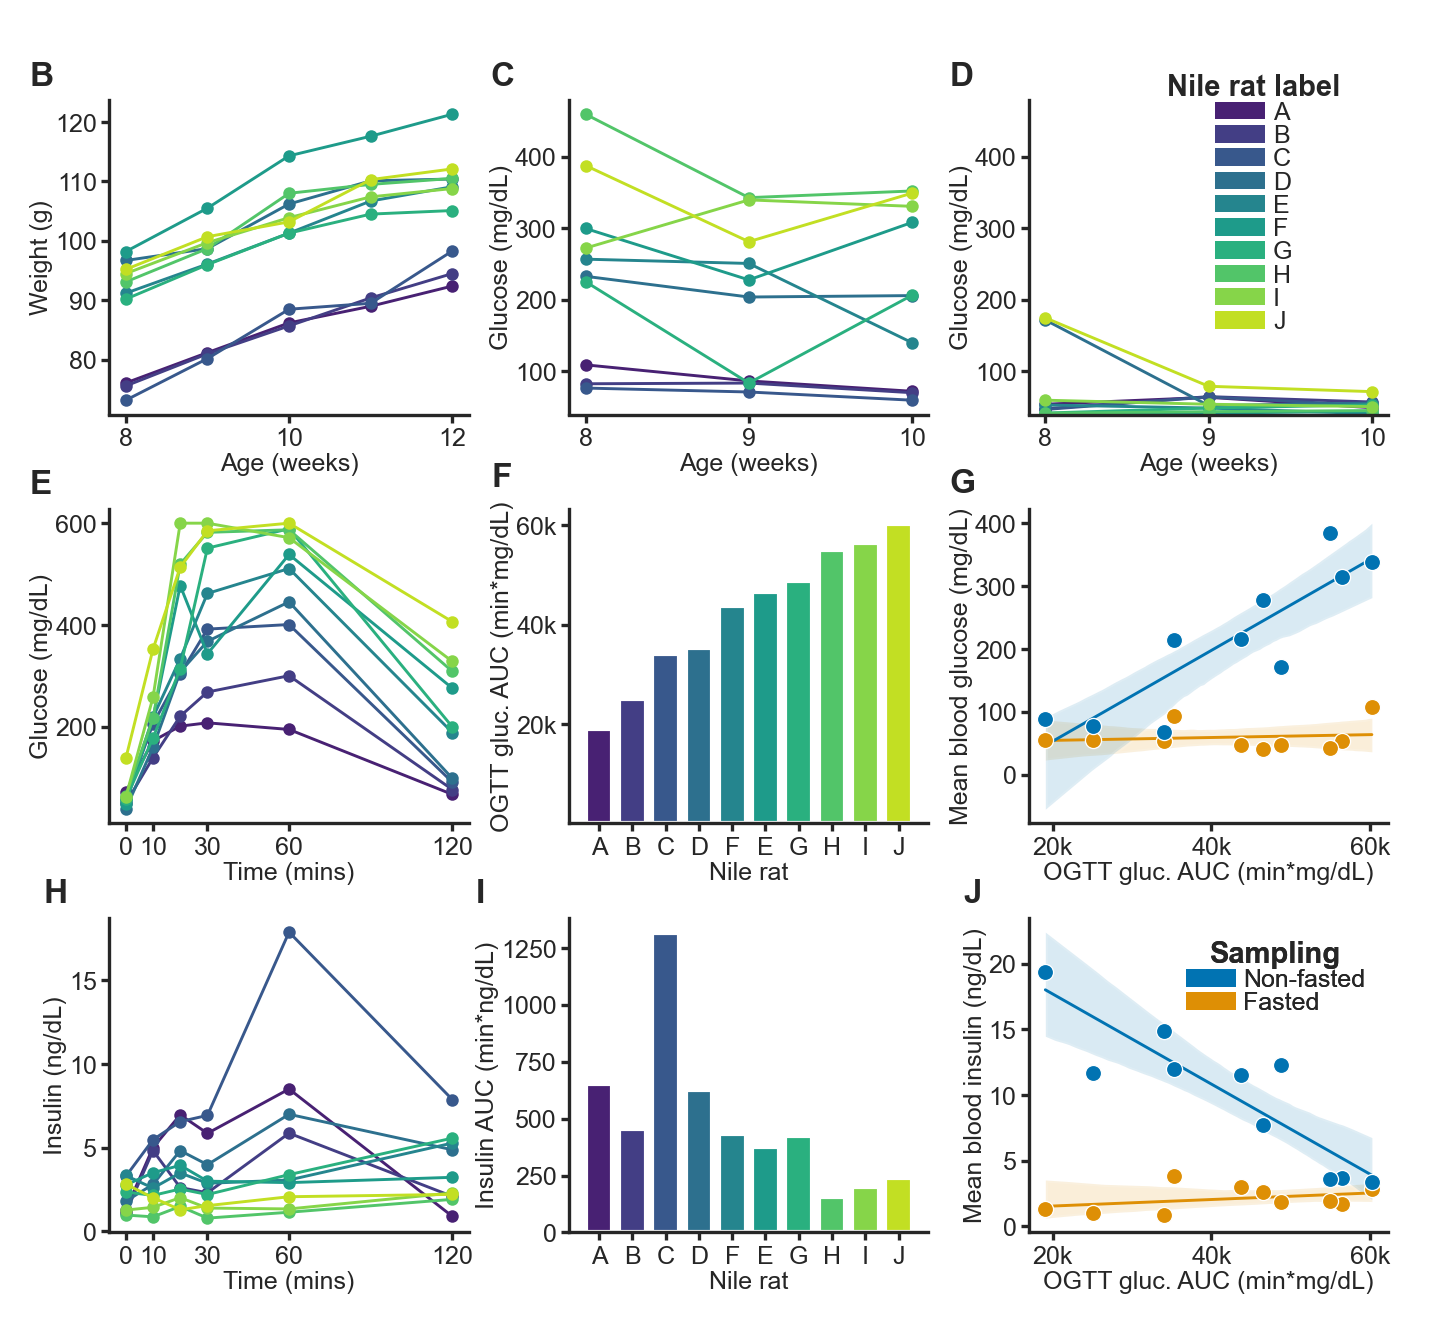

In [177]:
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 0.5

nrows, ncols = 3, 3
fig, a = plt.subplots(nrows=nrows, ncols=ncols, 
                      gridspec_kw={'hspace': 0.3, 'wspace': 0.28}, figsize=(5.5, 5), dpi=300)
a = a.ravel()
ms = 3
mec = '0.15'
mew = 0
lw = 0.7

### B ### Bodyweight
ax = a[0]
sns.lineplot(
    data=dfs['weight'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False, ax=ax)
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Weight (g)')

### C ### Nonfasted BG
ax = a[1]
sns.lineplot(
    data=dfs['RBG'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False, ax=ax)
ax.set_xticks([8, 9, 10])
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Glucose (mg/dL)')

### D ### Fasted BG
ax = a[2]
sns.lineplot(
    data=dfs['FBG'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False, ax=ax)
ax.set_xticks([8, 9, 10])
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Glucose (mg/dL)')
ax.set_ylim(a[1].get_ylim())


### E ###  OGTT glucose Curves
ax = a[3]
sns.lineplot(
    data=dfs['OGTT'], x='x', y='y', ax=ax,
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False)
ax.set_xticks(ticks=[0, 10, 30, 60, 120])
ax.set_xlabel('Time (mins)')
ax.set_ylabel('Glucose (mg/dL)')

### F ###  OGTT glucose AUC
ax = a[4]
ax.bar(x=bar_data['loc'], height=bar_data['OGTT (AUC)'], color=bar_data['color'].to_list())
# for loc, ogtt in zip(bar_data['loc'], bar_data['OGTT (AUC)']):
#     ax.annotate(str(int(round(ogtt, -3)))[:2] + 'k', xy=(loc, ogtt+1100), ha='center', zorder=9)
ax.set_xticks(ticks=range(10), labels=[x for x in 'ABCDFEGHIJ'])
ax.set_xlabel('Nile rat')
ax.set_yticks(ticks=[20000, 40000, 60000], labels=['20k', '40k', '60k'])
ax.set_ylabel('OGTT gluc. AUC (min*mg/dL)') 

### G ### INSULIN OGTT CURVE
ax = a[6]
sns.lineplot(
    data=dfs['ITT'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew,     
    legend=False, ax=ax)
ax.set_xticks(ticks=[0, 10, 30, 60, 120])
ax.set_xlabel('Time (mins)')
ax.set_ylabel('Insulin (ng/dL)')

### H ###  INSULIN AUC BAR
ax = a[7]
ax.bar(x=bar_data['loc'], height=bar_data['Insulin (AUC)'], color=bar_data['color'].to_list(),)
# for loc, ogtt in zip(bar_data['loc'], bar_data['Insulin (AUC)']):
#     ax.annotate(str(int(round(ogtt, 0))), xy=(loc, ogtt+50), ha='center', zorder=9)
ax.set_xticks(ticks=range(10), labels=[x for x in 'ABCDFEGHIJ'])
ax.set_xlabel('Nile rat')
ax.set_ylabel('Insulin AUC (min*ng/dL)')

### G ###
ax = a[5]
df = dfs['RBG'].groupby('animal').mean()
df = df.join(dfs['FBG'].groupby('animal').mean(), lsuffix='R', rsuffix='F')
df['animal_str'] = df.index.astype('str')
df = df.join(ap['OGTT (AUC)'])
sns.regplot(data=df, x='OGTT (AUC)', y='yF', ax=ax, color=colors['FBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Fasted insulin')
sns.regplot(data=df, x='OGTT (AUC)', y='yR', ax=ax, color=colors['RBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Nonfasted insulin')
sns.scatterplot(data=df, x='OGTT (AUC)', y='yF', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['FBG'], legend=False, zorder=2, edgecolors=colors['FBG'])
sns.scatterplot(data=df, x='OGTT (AUC)', y='yR', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['RBG'], legend=False, zorder=2, edgecolors=colors['RBG'])
ax.set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'])
ax.set_xlabel('OGTT gluc. AUC (min*mg/dL)')
ax.set_ylabel('Mean blood glucose (mg/dL)')

### J ###
ax = a[8]
df = dfs['Rinsulin'].groupby('animal').mean()
df = df.join(dfs['Finsulin'].groupby('animal').mean(), lsuffix='R', rsuffix='F')
df['animal_str'] = df.index.astype('str')
df = df.join(ap['OGTT (AUC)'])
sns.regplot(data=df, x='OGTT (AUC)', y='yF', ax=ax, color=colors['FBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Fasted insulin')
sns.regplot(data=df, x='OGTT (AUC)', y='yR', ax=ax, color=colors['RBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Nonfasted insulin')
sns.scatterplot(data=df, x='OGTT (AUC)', y='yF', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['FBG'], legend=False, zorder=2, edgecolors=colors['FBG'])
sns.scatterplot(data=df, x='OGTT (AUC)', y='yR', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['RBG'], legend=False, zorder=2, edgecolors=colors['RBG'])
ax.set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'])
ax.set_xlabel('OGTT gluc. AUC (min*mg/dL)')
ax.set_ylabel('Mean blood insulin (ng/dL)')


# a[-1][-1].remove()  # Remove the empty plot

legend = plt.legend(handles=[patches.Patch(facecolor=colors['RBG'], edgecolor='none', linewidth=0, label='Non-fasted'),
                     patches.Patch(facecolor=colors['FBG'], edgecolor='none', linewidth=0, label='Fasted')],
                    title='Sampling', title_fontproperties={'weight': 'semibold', 'size': 7}, 
                    labelspacing=0.01, handletextpad=0.3)
a[-1].add_artist(legend)

legend_patches = []
for color, label in zip(cmap, 'ABCDEFGHIJ'):
    legend_patches.append(patches.Patch(facecolor=color, edgecolor='none', linewidth=0, label=label))
fig.legend(handles=legend_patches, loc=(0.8, 0.74), 
           title='Nile rat label',  title_fontproperties={'weight': 'semibold', 'size': 7},
           markerscale=1.5, labelspacing=0.01, handletextpad=0.3)


for ax, letter in zip(a, 'BCDEFGHIJK'):
    bb = tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1+0.01, s=letter, transform=fig.transFigure, fontweight='bold', fontsize=8)
#     ax.annotate(letter, xy=(-0.25, 1.05), xycoords='axes fraction', fontsize=25, fontweight='bold')
#     ax.tick_params(labelsize=14)
for ax in a: 
    for pos in ax.spines:
        ax.spines[pos].set_linewidth(0.8)
sns.despine()
# plt.tight_layout()
# plt.savefig(r'..\reports\figures\0-1-1\all_phenotypes.pdf', bbox_inches='tight', dpi=100, facecolor='white')
# plt.savefig(r'..\reports\figures\0-1-1\all_phenotypes.png', bbox_inches='tight', dpi=100, facecolor='white')

In [43]:
test = (ap
        .loc[ap['lcms_sampled'], ['RBGweek8', 'RBGweek9', 'RBGweek10', 'RBGweek11']]
#         .filter(regex='^RBGweek')
#         .mean(axis=1).to_frame()
        .join(ap['OGTT (AUC)'])
        .reset_index()
       )
test = test.melt(id_vars=['animal', 'OGTT (AUC)']).dropna()
test

,animal,OGTT (AUC),variable,value
0,1060,48742.5,RBGweek8,225.000000
1,1062,43717.5,RBGweek8,256.500000
2,1074,35250.0,RBGweek8,232.500000
3,1076,60245.0,RBGweek8,387.666667
4,1082,56462.5,RBGweek8,272.000000
5,1091,19060.0,RBGweek8,108.500000
6,1092,34022.5,RBGweek8,76.000000
7,1093,25057.5,RBGweek8,82.000000
8,1101,55007.5,RBGweek8,459.500000
9,1102,46565.0,RBGweek8,299.500000


<AxesSubplot:xlabel='OGTT (AUC)', ylabel='value'>

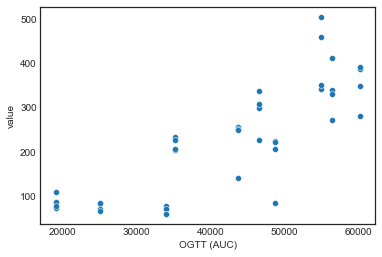

In [44]:
sns.scatterplot(
    data=test, x='OGTT (AUC)', y='value'
)